# Проект "Маркетинг"

**Цель проекта** - разработать модель машинного обучения, которая на основании данных о прошлых покупках и рекламных кампаниях будет предсказывать вероятность совершения покупки пользователем в течение 90 дней.

**Входные данные**
1. Данные о покупках пользователей.
   - Идентификатор пользователя (client_id)
   - Количество приобретаемых товаров (quantity)
   - Цена товара (price)
   - Категория приобретаемого товара (category_ids)
   - Дата покупки (date)
   - Идентификатор коммуникации с пользователем, благодаря которому покупка была совершена (message_id)
2. Данные о рекламных коммуникациях с пользователями.
   - Идентификатор рекламной кампании (bulk_campaign_id)
   - Идентификатор пользователя (client_id)
   - Идентификатор рекламной коммуникации (message_id)
   - Действие пользователя в результате рекламной коммуникации (event)
   - Способ рекламной коммуникации (channel)
   - Дата действия пользователя (date)
   - Дата коммуникации (created_at) 

**План работы**
1. Поверхностный обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных (EDA).
4. Создание новых признаков.
5. Корреляционный анализ данных.
6. Построение моделей машинного обучения.
7. Исследование значимости признаков.

## Импорты

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import is_classifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [6]:
RANDOM_STATE = 42

## Поверхностный обзор данных

In [8]:
# утилитная функция для открытия файла csv
def csv_reader(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Ошибка: Файл '{file_path}' не найден.")
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        raise RuntimeError(f"Непредвиденная ошибка: {e}")

In [9]:
# получение данных из входных файлов
df_messages = csv_reader("data/apparel-messages.csv")
df_purchases = csv_reader("data/apparel-purchases.csv")
df_target = csv_reader("data/apparel-target_binary.csv")

In [10]:
# общая информация по датасету
df_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [11]:
# общая информация по датасету
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [12]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   .client_id  49849 non-null  int64
 1   target      49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [13]:
# вывод 3 случайных записей
df_messages.sample(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
2637921,8031,1515915625499774637,1515915625499774637-8031-637c7a865ac4b,send,mobile_push,2022-11-22,2022-11-22 07:30:16
5441441,13069,1515915625490616151,1515915625490616151-13069-6479c8e122fec,send,mobile_push,2023-06-02,2023-06-02 11:02:13
6774359,13606,1515915625571266372,1515915625571266372-13606-64d0d63a8a5af,send,mobile_push,2023-08-07,2023-08-07 11:56:08


In [14]:
# вывод 3 случайных записей
df_purchases.sample(3)

,client_id,quantity,price,category_ids,date,message_id
153276,1515915625766443298,1,559.0,"['4', '28', '244', '432']",2023-07-05,1515915625766443298-13443-64a52fcd257ec
136444,1515915625558746685,1,123.0,"['4', '27', '172', '474']",2023-06-11,1515915625558746685-13319-6483f5ccf030c
175035,1515915625600646197,1,1090.0,"['4', '28', '58', '434']",2023-11-01,1515915625600646197-14022-653fa3e80649a


In [15]:
# количество дубликатов в датасете с коммуникациями
print(df_messages.duplicated().sum())
print(df_purchases.duplicated().sum())

48610
73020


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Промежуточные выводы о данных:
1. Пропуски во всех датасетах отсутствуют.
2. Есть дубликаты в датасете с данными о рекламных коммуникациях с пользователями (48610 дублей). 
3. В датасете с покупками также есть полные дубликаты (73020 дублей) - вероятнее всего была какая-то техническая специфика при сборе этих данных, что повлекло за собой наличие полных дубликатов.

</div>

In [17]:
# количество рекламных коммуникаций 
len(df_messages)

12739798

In [18]:
# обзор столбца event
df_messages['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [19]:
# обзор столбца channel
df_messages['channel'].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

In [20]:
# обзор столбца date
print(df_messages['date'].min())
print(df_messages['date'].max())

2022-05-19
2024-02-15


In [21]:
# обзор столбца client_id
df_messages['client_id'].nunique()

53329

In [22]:
# обзор столбца bulk_campaign_id
df_messages['bulk_campaign_id'].nunique()

2709

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Датасет с рекламными коммуникациями:
1. В наличии данные за промежуток с 19.05.2022 по 15.02.2024 (всего 12_739_798 наблюдений), включая 48610 дублей.
2. Всего было сделано 2709 рекламных кампаний в адрес 53329 пользователей.
3. Рекламные коммуникации осуществляются при помощи мобильных пуш-уведомлений и через электронную почту.
4. Действия пользователя в рамках рекламной коммуникации могут быть следующими:
   - send (уведомление отправлено, но реакции пользователя нет)
   - open (пользователь открыл рекламное уведомление)
   - click (пользователь перешел по ссылке в рекламном уведомлении)
   - purchase (пользователь приобрел товар в рамках рекламного уведомления)
   - hard_bounce (ошибка доставки, контактные данные получателя невалидны)
   - soft_bounce (временная ошибка доставки)
   - unsubscribe (отказ от дальнейший коммуникаций)
   - hbq_spam (сообщение распознано как спам на уровне программного обеспечения)
   - complain (жалоба пользователя на спам)
   - subscribe (подписка пользователя)
   - close (не очень понятное действие)

</div>

In [24]:
# количество покупок 
len(df_purchases)

202208

In [25]:
# обзор столбца date
print(df_purchases['date'].min())
print(df_purchases['date'].max())

2022-05-16
2024-02-16


In [26]:
# обзор столбца quantity
df_purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

In [27]:
# обзор столбца client_id
df_purchases['client_id'].nunique()

49849

In [28]:
# обзор столбца message_id
df_purchases['message_id'].nunique()

50204

In [29]:
# обзор столбца category_ids
df_purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">
    
Датасет с покупками:
1. В наличии данные за промежуток с 16.05.2022 по 16.02.2024 (всего 202_208 наблюдений), включая 73020 дублей.
2. Количество приобретаемого товара находится в промежутке от 1 до 30 штук.
3. В датасете представлены данные по 49849 уникальным пользователям.
4. В датасете представлены покупки, которые были сделаны на основании 50204 рекламных коммуникаций с пользователями.
5. Каждая покупка может быть описана при помощи 4-уровневой категории товара. 

</div>

## Предобработка данных

In [32]:
# удаляем дубликаты
df_purchases.drop_duplicates(inplace=True)
df_purchases = df_purchases.reset_index(drop=True)

df_messages.drop_duplicates(inplace=True)
df_messages = df_messages.reset_index(drop=True)

In [33]:
# проверка количества дубликатов после удаления
print(df_purchases.duplicated().sum())
print(df_messages.duplicated().sum())

0
0


In [34]:
# преобразование в datetime
df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_messages['date'] = pd.to_datetime(df_messages['date'])

In [35]:
# создание столбца total_cost
df_purchases['total_cost'] = df_purchases['price'] * df_purchases['quantity']

In [36]:
df_target = df_target.rename(columns={'.client_id': 'client_id'})

## Исследовательский анализ данных (EDA)

### Выручка по месяцам

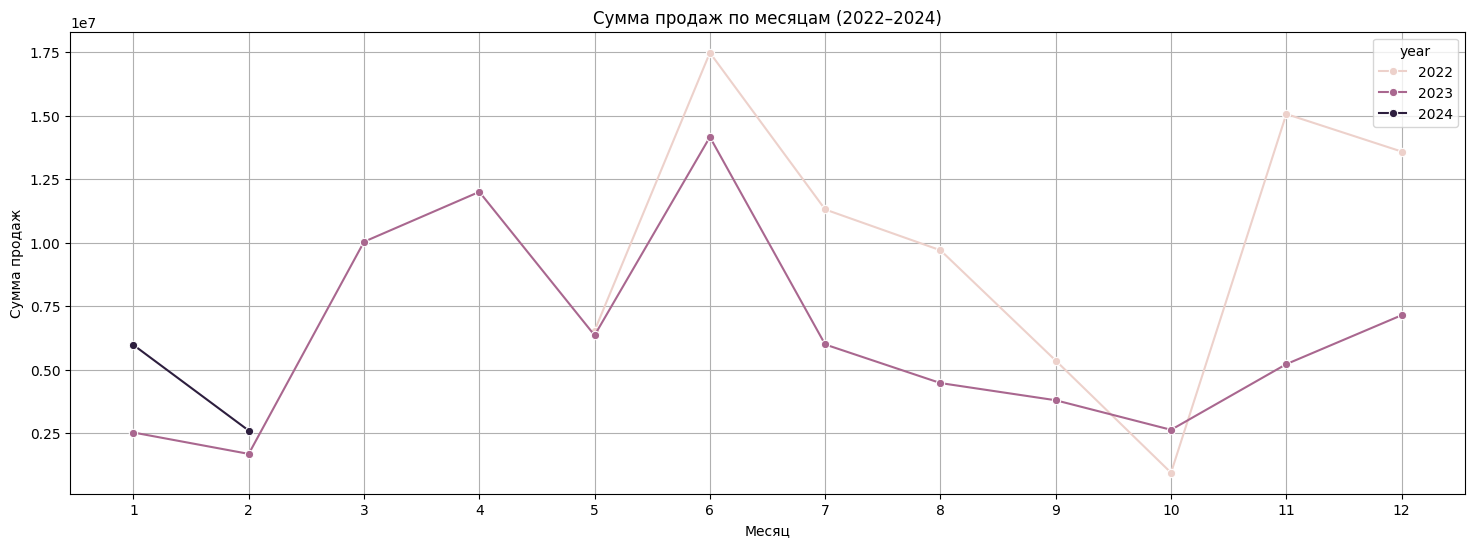

In [39]:
df_purchases['year'] = df_purchases['date'].dt.year
df_purchases['month'] = df_purchases['date'].dt.month

monthly_sales = df_purchases.groupby(['year', 'month'])['total_cost'].sum().reset_index()

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_sales,
    x='month',
    y='total_cost',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж')
plt.title('Сумма продаж по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Количество рекламных коммуникаций

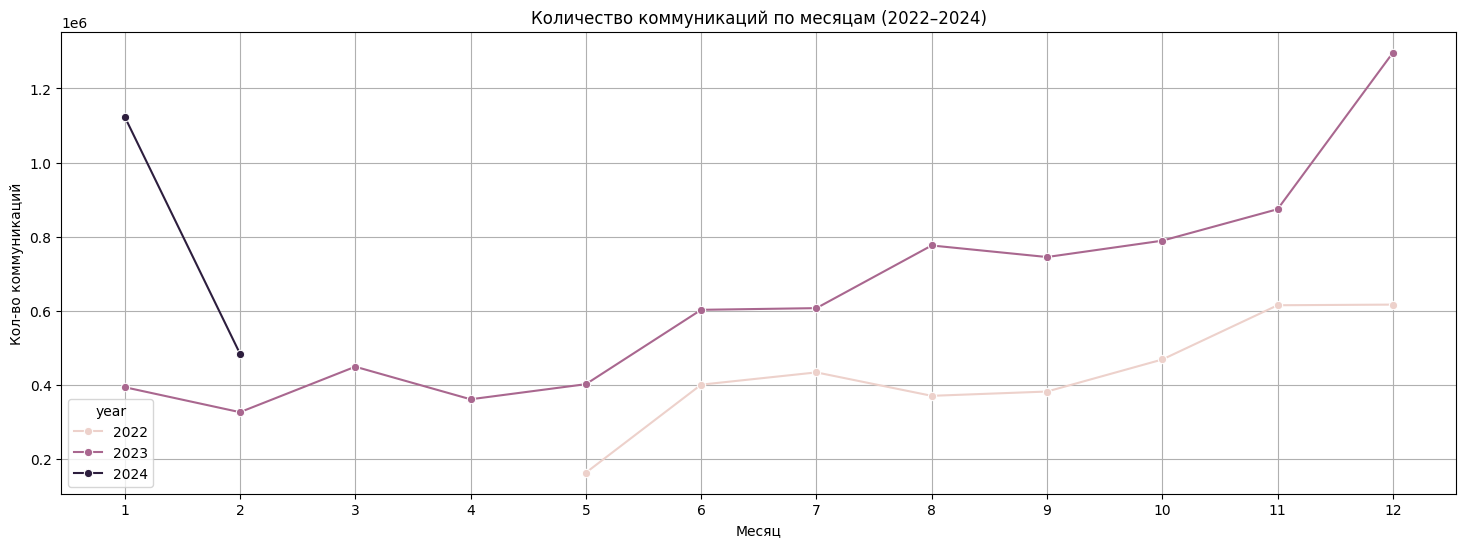

In [41]:
df_messages['year'] = df_messages['date'].dt.year
df_messages['month'] = df_messages['date'].dt.month

monthly_messages = df_messages.groupby(['year', 'month'], observed=True)['message_id'].size().reset_index(name='messages_count')

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_messages,
    x='month',
    y='messages_count',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Кол-во коммуникаций')
plt.title('Количество коммуникаций по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Количество рекламных коммуникаций с покупкой

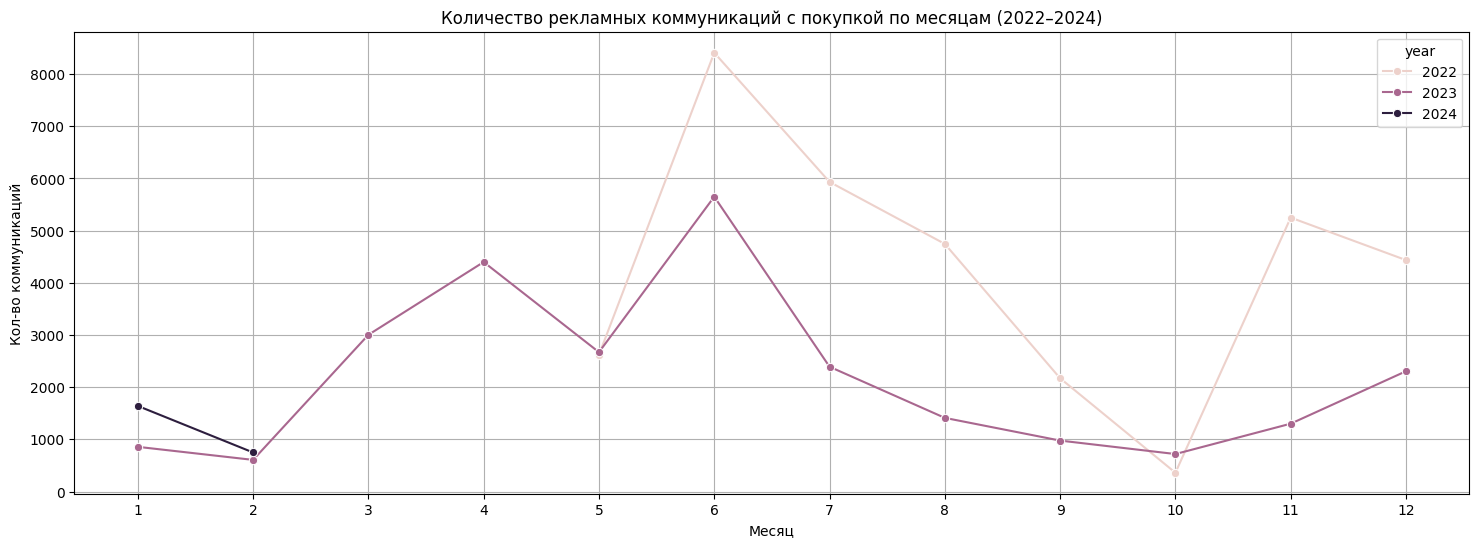

In [43]:
df_successful_messages = df_messages.query('event == "purchase"')

monthly_messages = df_successful_messages.groupby(['year', 'month'])['message_id'].size().reset_index(name='messages_count')

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_messages,
    x='month',
    y='messages_count',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Кол-во коммуникаций')
plt.title('Количество рекламных коммуникаций с покупкой по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Способ рекламной коммуникации

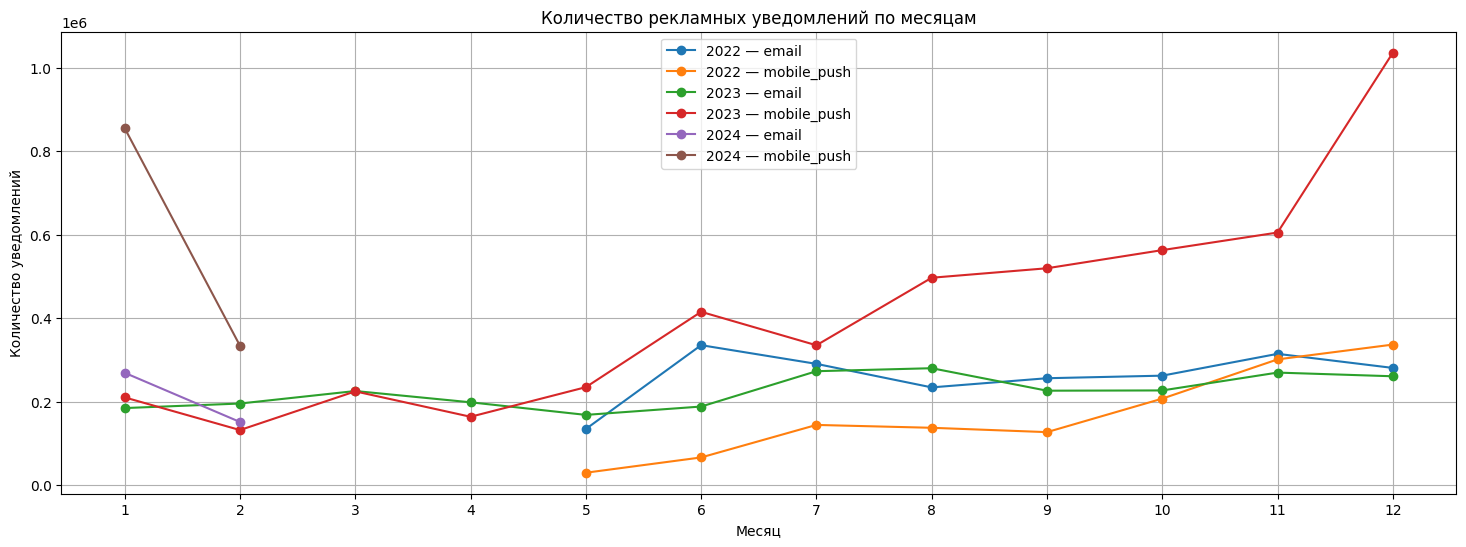

In [45]:
agg = (
    df_messages.groupby(['year', 'month', 'channel'], observed=True)
      .size()
      .reset_index(name='cnt')
)

plt.figure(figsize=(18, 6))

years = [2022, 2023, 2024]
channels = ['email', 'mobile_push']

for year in years:
    for channel in channels:
        data = agg[(agg['year'] == year) & (agg['channel'] == channel)]
        plt.plot(
            data['month'],
            data['cnt'],
            marker='o',
            label=f'{year} — {channel}'
        )

plt.title('Количество рекламных уведомлений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уведомлений')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)

plt.show()

### Реакция пользователей на рекламную коммуникацию

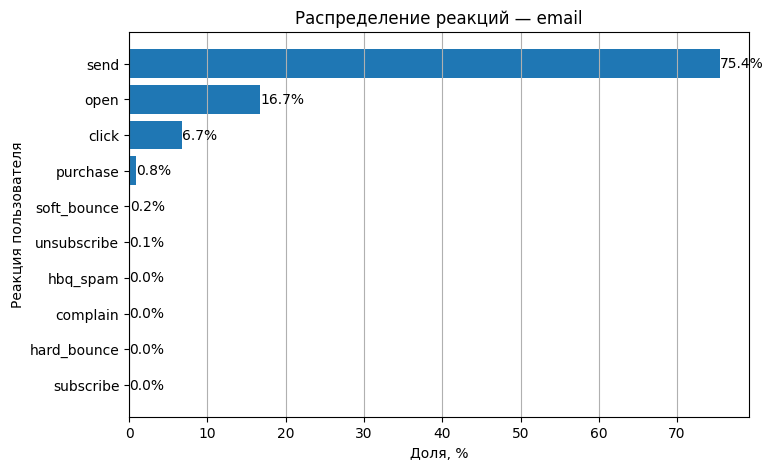

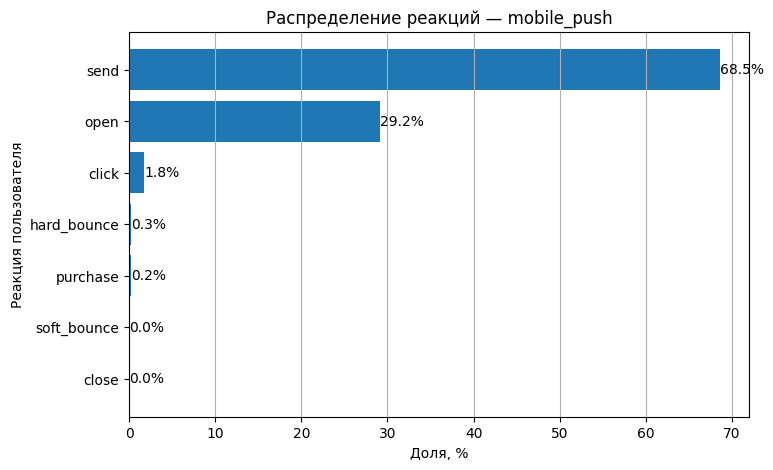

In [47]:
channels = ['email', 'mobile_push']

for channel in channels:
    counts = (
        df_messages[df_messages['channel'] == channel]
        .groupby('event')
        .size()
        .sort_values()
    )

    percents = counts / counts.sum() * 100

    plt.figure(figsize=(8, 5))
    plt.barh(percents.index, percents.values)

    for i, v in enumerate(percents.values):
        plt.text(v, i, f'{v:.1f}%', va='center')

    plt.title(f'Распределение реакций — {channel}')
    plt.xlabel('Доля, %')
    plt.ylabel('Реакция пользователя')
    plt.grid(axis='x')

    plt.show()

### Реакция пользователей на рекламную коммуникацию в части сделанных покупок 

In [49]:
df_result = df_purchases.merge(
    df_messages,
    on="message_id",
    how="inner"
)

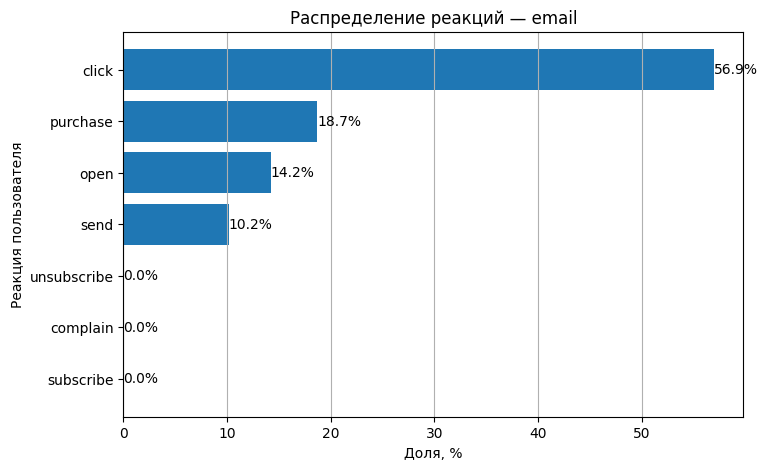

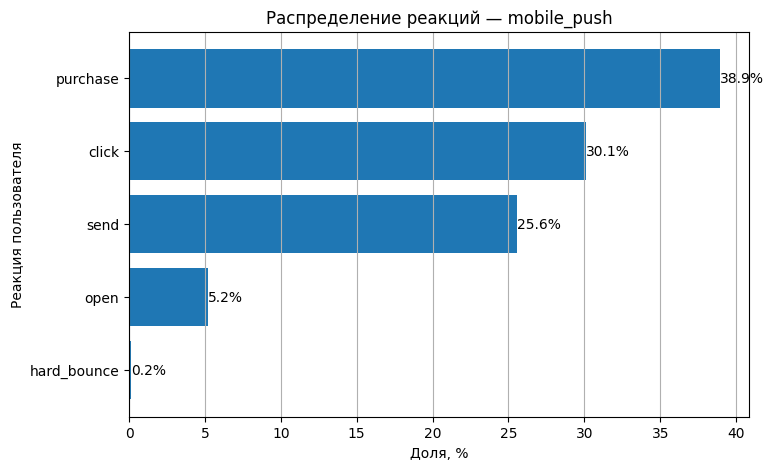

In [50]:
channels = ['email', 'mobile_push']

for channel in channels:
    counts = (
        df_result[df_result['channel'] == channel]
        .groupby('event')
        .size()
        .sort_values()
    )

    percents = counts / counts.sum() * 100

    plt.figure(figsize=(8, 5))
    plt.barh(percents.index, percents.values)

    for i, v in enumerate(percents.values):
        plt.text(v, i, f'{v:.1f}%', va='center')

    plt.title(f'Распределение реакций — {channel}')
    plt.xlabel('Доля, %')
    plt.ylabel('Реакция пользователя')
    plt.grid(axis='x')

    plt.show()

## Создание новых признаков

### Сумма покупок по месяцам

In [53]:
df = (
    df_purchases
    .groupby(['client_id', 'year', 'month'])['total_cost']
    .sum()
    .reset_index()
    .pivot(index='client_id', columns=['year', 'month'], values='total_cost')
    .fillna(0)
)

# делаем плоские названия столбцов
df.columns = [f'{year}_{month:02d}' for year, month in df.columns]

df = df.reset_index()

In [54]:
df.head(100)

,client_id,2022_05,2023_01,2024_02,2023_03,2023_06,2022_07,2022_08,2022_11,2022_12,...,2022_06,2022_09,2022_10,2023_05,2024_01,2023_02,2023_08,2023_09,2023_10,2023_11
0,1515915625468060902,4795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,14135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625468061099,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625468061100,0.0,0.0,1049.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625468061170,0.0,0.0,0.0,13103.0,999.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1515915625468068931,0.0,0.0,0.0,0.0,2095.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1515915625468068974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1515915625468069037,0.0,0.0,0.0,0.0,0.0,4597.0,999.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1515915625468069101,0.0,0.0,0.0,0.0,0.0,0.0,1799.0,0.0,0.0,...,3897.0,0.0,3596.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Количество рекламных коммуникаций по месяцам

In [56]:
msg_counts = (
    df_messages
    .groupby(['client_id', 'year', 'month', 'channel'])
    .size()
    .reset_index(name='cnt')
    .pivot_table(
        index='client_id',
        columns=['year', 'month', 'channel'],
        values='cnt',
        fill_value=0
    )
)

# делаем плоские названия столбцов
msg_counts.columns = [f'{year}_{month:02d}_{channel}' for year, month, channel in msg_counts.columns]

msg_counts = msg_counts.reset_index()

In [57]:
df = df.merge(msg_counts, on='client_id', how='left')

# заполняем NaN нулями, если клиент не получал сообщений
df.fillna(0, inplace=True)

In [58]:
df.head(10)

,client_id,2022_05,2023_01,2024_02,2023_03,2023_06,2022_07,2022_08,2022_11,2022_12,...,2023_10_email,2023_10_mobile_push,2023_11_email,2023_11_mobile_push,2023_12_email,2023_12_mobile_push,2024_01_email,2024_01_mobile_push,2024_02_email,2024_02_mobile_push
0,1515915625468060902,4795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,9.0,0.0,11.0,0.0,13.0,0.0,0.0,0.0
1,1515915625468061003,0.0,14135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,9.0,0.0,5.0,0.0,5.0,0.0,4.0,0.0
2,1515915625468061099,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,6.0,0.0,9.0,0.0,12.0,0.0,5.0,0.0
3,1515915625468061100,0.0,0.0,1049.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,37.0,0.0,33.0,0.0,60.0,0.0,31.0,0.0,25.0
4,1515915625468061170,0.0,0.0,0.0,13103.0,999.0,0.0,0.0,0.0,0.0,...,10.0,2.0,10.0,19.0,13.0,35.0,13.0,28.0,7.0,7.0
5,1515915625468061514,0.0,0.0,0.0,0.0,0.0,999.0,0.0,0.0,0.0,...,10.0,0.0,14.0,0.0,9.0,0.0,9.0,0.0,4.0,0.0
6,1515915625468061877,0.0,0.0,0.0,0.0,0.0,0.0,1499.0,0.0,0.0,...,0.0,21.0,0.0,25.0,0.0,40.0,0.0,24.0,0.0,11.0
7,1515915625468061975,0.0,0.0,0.0,0.0,0.0,299.0,0.0,0.0,0.0,...,7.0,0.0,9.0,0.0,9.0,0.0,3.0,0.0,4.0,0.0
8,1515915625468061994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199.0,655.0,...,6.0,20.0,5.0,13.0,7.0,32.0,8.0,24.0,3.0,7.0
9,1515915625468062158,4698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,7.0,0.0,9.0,0.0,12.0,0.0,5.0,0.0


### Частота реакций при покупках

In [60]:
reaction_counts = (
    df_messages
    .groupby(['client_id', 'channel', 'event'])
    .size()
    .reset_index(name='total_events')
)

In [61]:
reaction_counts.head(10)

,client_id,channel,event,total_events
0,1515915625468060902,email,click,10
1,1515915625468060902,email,open,35
2,1515915625468060902,email,purchase,5
3,1515915625468060902,email,send,126
4,1515915625468060902,email,unsubscribe,1
5,1515915625468061003,email,click,5
6,1515915625468061003,email,open,5
7,1515915625468061003,email,purchase,1
8,1515915625468061003,email,send,154
9,1515915625468061099,email,click,8


In [62]:
pivot_df = reaction_counts.pivot_table(
    index='client_id',
    columns='event',
    values='total_events',
    fill_value=0
).reset_index()

# Вычисляем долю purchase от send, подставляем NaN если send == 0
pivot_df['purchase_ratio'] = np.where(
    pivot_df['send'] == 0,
    0,
    pivot_df['purchase'] / pivot_df['send']
)

df = df.merge(
    pivot_df[['client_id', 'purchase_ratio']], 
    on='client_id', 
    how='inner'
)

In [63]:
print(df.columns)

Index(['client_id', '2022_05', '2023_01', '2024_02', '2023_03', '2023_06',
       '2022_07', '2022_08', '2022_11', '2022_12', '2023_04', '2023_07',
       '2023_12', '2022_06', '2022_09', '2022_10', '2023_05', '2024_01',
       '2023_02', '2023_08', '2023_09', '2023_10', '2023_11', '2022_05_email',
       '2022_05_mobile_push', '2022_06_email', '2022_06_mobile_push',
       '2022_07_email', '2022_07_mobile_push', '2022_08_email',
       '2022_08_mobile_push', '2022_09_email', '2022_09_mobile_push',
       '2022_10_email', '2022_10_mobile_push', '2022_11_email',
       '2022_11_mobile_push', '2022_12_email', '2022_12_mobile_push',
       '2023_01_email', '2023_01_mobile_push', '2023_02_email',
       '2023_02_mobile_push', '2023_03_email', '2023_03_mobile_push',
       '2023_04_email', '2023_04_mobile_push', '2023_05_email',
       '2023_05_mobile_push', '2023_06_email', '2023_06_mobile_push',
       '2023_07_email', '2023_07_mobile_push', '2023_08_email',
       '2023_08_mobile_push', 

In [64]:
df.head()

,client_id,2022_05,2023_01,2024_02,2023_03,2023_06,2022_07,2022_08,2022_11,2022_12,...,2023_10_mobile_push,2023_11_email,2023_11_mobile_push,2023_12_email,2023_12_mobile_push,2024_01_email,2024_01_mobile_push,2024_02_email,2024_02_mobile_push,purchase_ratio
0,1515915625468060902,4795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,11.0,0.0,13.0,0.0,0.0,0.0,0.039683
1,1515915625468061003,0.0,14135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,5.0,0.0,5.0,0.0,4.0,0.0,0.006494
2,1515915625468061099,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,9.0,0.0,12.0,0.0,5.0,0.0,0.000000
3,1515915625468061100,0.0,0.0,1049.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,0.0,33.0,0.0,60.0,0.0,31.0,0.0,25.0,0.003745
4,1515915625468061170,0.0,0.0,0.0,13103.0,999.0,0.0,0.0,0.0,0.0,...,2.0,10.0,19.0,13.0,35.0,13.0,28.0,7.0,7.0,0.024691


## Обучение моделей

In [66]:
df = df.merge(df_target, on='client_id', how='inner')

In [67]:
X = df.drop('target', axis=1) 
y = df['target']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

In [69]:
# decision tree
pipe_dt = Pipeline([
    ('scaler', 'passthrough'),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_dt = {
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 10, 20],
}

# random forest
pipe_rf = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 15],
}

# knn
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_knn = {
    'model__n_neighbors': [5, 7, 9],
}

# svc 
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(
        kernel='rbf',
        gamma='scale',
        probability=False,
        random_state=RANDOM_STATE
    ))
])

param_svc = {
    'model__C': [0.1, 1, 10],
}

# catboost 
pipe_cat = Pipeline([
    ('scaler', 'passthrough'),
    ('model', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        loss_function='Logloss',
        iterations=150
    ))
])

param_cat = {
    'model__depth': [4, 6],
    'model__learning_rate': [0.03, 0.1],
}

# XGBoost
pipe_xgb = Pipeline([
    ('scaler', 'passthrough'),
    ('model', XGBClassifier(
        random_state=RANDOM_STATE,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1
    ))
])

param_xgb = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.03, 0.1],
}

# LightGBM
pipe_lgbm = Pipeline([
    ('scaler', 'passthrough'),
    ('model', LGBMClassifier(
        random_state=RANDOM_STATE,
        objective='binary',
        n_jobs=-1
    ))
])

param_lgbm = {
    'model__learning_rate': [0.03, 0.1],
    'model__max_depth': [-1, 10, 20]
}

In [70]:
# baseline search
search_spaces = {
    'DecisionTree': (pipe_dt, param_dt),
    'RandomForest': (pipe_rf, param_rf),
    'KNN': (pipe_knn, param_knn),
    'SVC': (pipe_svc, param_svc),
    'CatBoost': (pipe_cat, param_cat),
    'XGBoost': (pipe_xgb, param_xgb),
    'LightGBM': (pipe_lgbm, param_lgbm)
}

results = {}

for name, (pipe, params) in search_spaces.items():
    print(f'\n{name}')
    
    search = GridSearchCV(
        pipe,
        param_grid=params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    results[name] = search.best_score_
    
    print(f'ROC-AUC: {search.best_score_:.4f}')



DecisionTree
ROC-AUC: 0.6204

RandomForest
ROC-AUC: 0.7166

KNN
ROC-AUC: 0.5402

SVC
ROC-AUC: 0.5838

CatBoost
ROC-AUC: 0.7195

XGBoost
ROC-AUC: 0.7229

LightGBM
[LightGBM] [Info] Number of positive: 592, number of negative: 28795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7243
[LightGBM] [Info] Number of data points in the train set: 29387, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020145 -> initscore=-3.884450
[LightGBM] [Info] Start training from score -3.884450
ROC-AUC: 0.7190


In [71]:
# выбор лучшей модели
sorted(results.items(), key=lambda x: x[1], reverse=True)

[('XGBoost', np.float64(0.7229370625865258)),
 ('CatBoost', np.float64(0.7195036467955749)),
 ('LightGBM', np.float64(0.7189560654342765)),
 ('RandomForest', np.float64(0.7166417029991279)),
 ('DecisionTree', np.float64(0.6204094103616337)),
 ('SVC', np.float64(0.5837767813615221)),
 ('KNN', np.float64(0.5402142818265893))]

In [72]:
# cat boost tuning
pipe_cat_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        loss_function='Logloss',
        early_stopping_rounds=30
    ))
])

param_cat_final = {
    'model__iterations': [200, 400],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.1],
    'model__l2_leaf_reg': [1, 3, 5],
}

search_cat = RandomizedSearchCV(
    pipe_cat_final,
    param_cat_final,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search_cat.fit(X_train, y_train)

print('Лучшие гиперпараметры CatBoost:\n')
for param, value in search_cat.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры CatBoost:

model__learning_rate: 0.03
model__l2_leaf_reg: 5
model__iterations: 400
model__depth: 8


In [73]:
# random forest tuning
pipe_rf_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=1
    ))
])

param_rf_final = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 3, 5],
}

search_rf = RandomizedSearchCV(
    pipe_rf_final,
    param_rf_final,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

search_rf.fit(X_train, y_train)

print('Лучшие гиперпараметры RandomForest:\n')
for param, value in search_rf.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры RandomForest:

model__n_estimators: 400
model__min_samples_split: 2
model__min_samples_leaf: 1
model__max_depth: 10


In [74]:
best_model = max(
    [search_cat, search_rf],
    key=lambda s: s.best_score_
)

print(best_model.best_estimator_)
print(best_model.best_score_)

Pipeline(steps=[('scaler', 'passthrough'),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x114553ad0>)])
0.7317798322839633
